<h1 style="text-align: center;"> Evaluación Módulo II: Predicción del precio inmobiliario.  </h1>
<p align="center">
  <img src="https://cdn.prod.website-files.com/649475f4d573d5d9d1522659/649475f4d573d5d9d1522705_logo-track-ciencia.webp" alt="Logo Track Ciencia">
</p>

**Contexto del caso**

El caso de uso trata sobre un conjunto de datos recolectados y proporcionados por el Institut Louis Bachelier (ILB) sobre el real estate en Francia en donde el objetivo se centra en una tarea de regresión para poder predecir costos estimados inmobiliarios.

**Objetivos del reto**

- Este reto busca que los estudiantes comparen la diferencia entre los polinomios y las redes neuronales como funciones de Machine Learning.
- Considerando la base de datos ya utilizada en el curso de WA, Evaluación II (House Pricing) con información de propiedades, se deben de tomar las tres variables numéricas (ni binarias
ni categóricas) más correlacionadas con el costo de las propiedades
- Se deben de entrenar por separado una regresión polinomial con el polinomio sin un grado fijo y una red neuronal sin un número fijo de neuronaso capas.
- El alumno fijará una definición cuantitativa del sobre-ajuste que sea adecuada al problema de regresión que se está solucionando.
- Contar en ambos modelos el número de parámetros entrenables a partir del cual ocurre el sobre-ajuste. Recomendamos jugar con todos los parámetros involucrados.
- ¿Qué nos dice esto sobre la comparación entre redes y polinomios como funciones no-lineales?


***Nota: En el reto original se nos da datos con imagenes, estas se pueden omitir (No descartar para futuras pruebas con estos datos).***

**Descripción de los datos:**
Se trata de dos archivos CSV, uno con la características explicativas (X) y otro con la etiqueta (y).

La etiqueta (y) representa el precio en euros de bienes inmuebles en Francia. 

Las características (X) contienen:
- Un identificador del anuncio
- El tipo de propiedad (casa, apartamento, condominio, mansión...)
- La ubicación (latitud aproximada, longitud aproximada, ciudad, código postal, exposición, piso cuando proceda...)
- El tamaño (superficie habitable y superficie del terreno cuando proceda),
- El número de habitaciones, dormitorios, baños...
- Indicadores de eficiencia energética (energía y emisiones de gases de efecto invernadero)
- El número de fotos adjuntas al anuncio
- Indicadores de si hay sótano, balcón, aire acondicionado...

Además se presenta un diccionario de datos en formato xlsx

# Librerias

In [36]:
# Librerias para análisis
import pandas as pd
import numpy as np

# Librerias para ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers.legacy import Adam


# Librerias para visualización
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Funciones

In [37]:
def describe_datos(df):
    unicos = []
    for col in df.columns:
        try:
            unicos.append(df[col].unique())
        except:
            unicos.append(np.array([df[col].iloc[0]]))  # fallback si falla
    unicos = pd.Series(unicos, index=df.columns)
    descripcion = pd.concat([df.dtypes, df.isna().sum(), df.nunique(), unicos], axis=1)
    descripcion.columns = ['dtypes', 'null', 'nunique', 'unique']
    return descripcion

In [38]:
def grafica_distribuciones(df):
    # Seleccionamos solo las columnas numéricas
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

    # Definimos las dimensiones del grid de subplots de forma dinámica
    num_cols = len(numeric_cols)
    ncols = 3
    nrows = int(np.ceil(num_cols / ncols))
    
    # Crear los subplots
    fig, subplot = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 4 * nrows))
    subplot = subplot.flatten() # Para iterar fácilmente

    # Graficamos
    for i, col in enumerate(numeric_cols):
        df[col].dropna().hist(bins=50, color='blue', alpha=0.7, ax=subplot[i], density=True)
        subplot[i].set_title(f'{col} - Distribución')
        subplot[i].set_xlabel(col)
        subplot[i].set_ylabel('Frecuencia')
        
    for j in range(i + 1, len(subplot)):
        subplot[j].set_visible(False)

    plt.tight_layout()
    plt.show()

# Lectura de datos.

Cargamos nuestra etiqueta: $Y$

In [39]:
# Variables respuesta
Ys = pd.read_csv('/Users/danielml/Documents/Computational/Curso_Bourbaki/Working_Analyst/Evaluacion_Modulo_2/Datos/y.csv')
print(Ys.shape)
Ys.head()

(37368, 2)


,id_annonce,price
0,35996577,355000.0
1,35811033,190000.0
2,35731841,39000.0
3,35886765,299000.0
4,35781137,478000.0


Cargamos nuestros features: $X$

In [40]:
# Conjunto de caracteristicas (X)
X = pd.read_csv('/Users/danielml/Documents/Computational/Curso_Bourbaki/Working_Analyst/Evaluacion_Modulo_2/Datos/x.csv')
print(X.shape)
X.head()

(37368, 27)


,id_annonce,property_type,approximate_latitude,approximate_longitude,city,postal_code,size,floor,land_size,energy_performance_value,...,nb_parking_places,nb_boxes,nb_photos,has_a_balcony,nb_terraces,has_a_cellar,has_a_garage,has_air_conditioning,last_floor,upper_floors
0,35996577,appartement,43.643880,7.117183,villeneuve-loubet,6270,63.0,NaN,NaN,NaN,...,0.0,0.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,35811033,appartement,45.695757,4.895610,venissieux,69200,90.0,3.0,NaN,223.0,...,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,35731841,maison,47.966791,-1.220451,moutiers,35130,61.0,NaN,370.0,NaN,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,35886765,maison,47.289292,-1.878805,cordemais,44360,142.0,NaN,764.0,217.0,...,0.0,1.0,8.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,35781137,appartement,45.718992,4.844234,lyon-7eme,69007,88.0,3.0,NaN,NaN,...,0.0,1.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


Por comodidad vamos a unir los dos conjuntos de datos en uno solo. Asi como también hemos convertido o suavizado los valores de la columna price debido al siguiente comportamiento y visualización de la columna `price`:

<AxesSubplot: title={'center': 'Promedio de variable objetivo = 343221€a'}, ylabel='Frequency'>

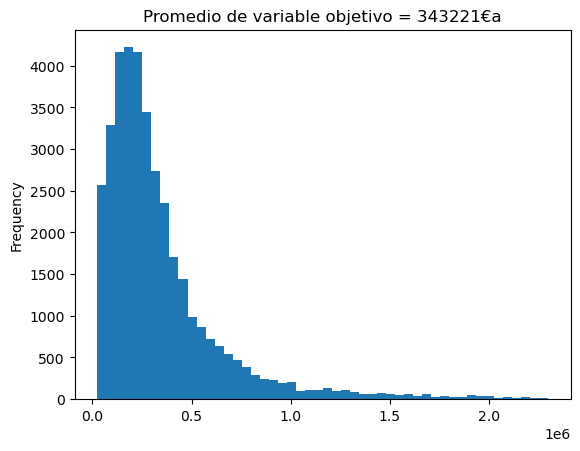

In [41]:
df = pd.merge(X, Ys, on="id_annonce")
df["log_price"] = np.log(df["price"])

# skewed target
df["price"].plot(
    kind="hist", bins=50, title=f"Promedio de variable objetivo = {df['price'].mean():.0f}€a"
)

Con la transformación a logaritmo:

<AxesSubplot: title={'center': 'Promedio de variable objetivo = 12€a'}, ylabel='Frequency'>

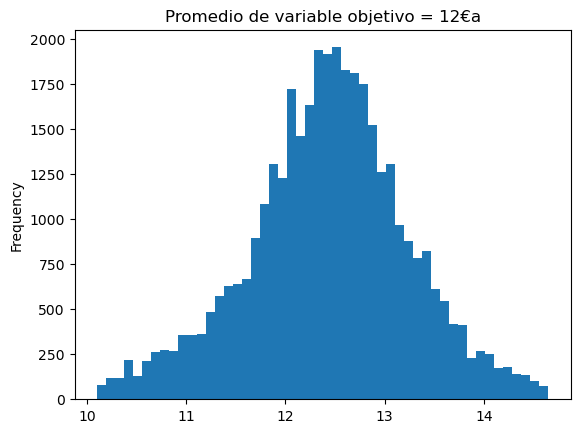

In [42]:
# skewed target
df["log_price"].plot(
    kind="hist", bins=50, title=f"Promedio de variable objetivo = {df['log_price'].mean():.0f}€a"
)

In [43]:
describe_datos(df)

,dtypes,null,nunique,unique
id_annonce,int64,0,37368,"[35996577, 35811033, 35731841, 35886765, 35781..."
property_type,object,0,22,"[appartement, maison, propriété, divers, duple..."
approximate_latitude,float64,0,37368,"[43.64387987003234, 45.695756723197945, 47.966..."
approximate_longitude,float64,0,37368,"[7.117182951005137, 4.89560993095212, -1.22045..."
city,object,0,8643,"[villeneuve-loubet, venissieux, moutiers, cord..."
postal_code,int64,0,4726,"[6270, 69200, 35130, 44360, 69007, 91380, 9220..."
size,float64,512,4478,"[63.0, 90.0, 61.0, 142.0, 88.0, 92.0, 1758.0, ..."
floor,float64,27625,24,"[nan, 3.0, 5.0, 1.0, 2.0, 55.0, 6.0, 4.0, 8.0,..."
land_size,float64,21787,3721,"[nan, 370.0, 764.0, 25700.0, 392.0, 2600.0, 78..."
energy_performance_value,float64,18300,642,"[nan, 223.0, 217.0, 161.0, 193.0, 89.0, 220.0,..."


# Análisis Exploratorio de los Datos.

De lo anterior podemos ver que para nuestros features sobresalen algunos aspectos, los cuales son:
- Gran cantidad de valores nulos en algunas columnas por lo que vamos a analizar como tratarlos.
- Columnas que deben de ser convertidas a datos categoricos, asi como ver algunas formas de tratarlos.
- Columnas que no nos van a aportar ninguna información por lo que pueden ser eliminadas.
- También vamos a tener que para property_type será para "house", floor será 0 y para "appartement", lot_size será 0.

In [44]:
columnas_con_nulos = df.columns[df.isna().any()].tolist()

# Ver el número de nulos por columna según tipo de propiedad
conteo_nulos_por_tipo = {}
for col in columnas_con_nulos:
    if col not in ['price']:  # Excluir price
        conteo_nulos_por_tipo[col] = X[X[col].isna()]['property_type'].value_counts()

# Detectar columnas binarias donde 0 podría ser una imputación válida
binarias_posibles = []
for col in columnas_con_nulos:
    if X[col].dropna().nunique() == 1 and X[col].dropna().unique()[0] == 0:
        binarias_posibles.append(col)

# Revisar también si hay columnas con nulos que están muy ligadas a un solo tipo de propiedad
conteo_nulos_por_tipo_df = pd.DataFrame(conteo_nulos_por_tipo).fillna(0).astype(int)
conteo_nulos_por_tipo_df

,size,floor,land_size,energy_performance_value,energy_performance_category,ghg_value,ghg_category,exposition,nb_rooms,nb_bedrooms,nb_bathrooms
property_type,,,,,,,,,,,
appartement,102,6135,15087,7984,7984,8156,8156,11291,56,1122,5870
atelier,0,2,2,1,1,1,1,0,0,0,0
chalet,1,48,6,22,22,22,22,29,1,0,10
chambre,0,2,4,3,3,3,3,4,0,4,1
château,0,21,3,14,14,14,14,14,0,0,5
divers,227,2137,1886,1769,1769,1776,1776,1993,1386,1462,1974
duplex,2,77,213,90,90,93,93,113,0,1,57
ferme,0,130,13,68,68,67,67,81,0,0,34
gîte,0,3,3,3,3,3,3,2,0,0,2


In [45]:
df.loc[(df['property_type'] != "appartement") & df['floor'].isna(), 'floor'] = 0          
df.loc[(df['property_type'] == "appartement") & df['land_size'].isna(), 'land_size'] = 0

In [46]:
cols_drop = ['nb_photos', 'energy_performance_category', 'ghg_category'] # Se eliminan las dos ultimas columnas porque hay una derivación 
                                                                                       # por otra columna que nos podría dar mas información.
df = df.drop(columns=cols_drop)

In [47]:
# Imputar 'exposition' con 0 directamente
df['exposition'] = df['exposition'].fillna(0)

# Imputar otras con lógica basada en el tipo de propiedad
for col in ['nb_rooms', 'nb_bedrooms', 'nb_bathrooms']:
    # Si no es 'appartement' o 'maison', se asume que puede no tener esas características
    df.loc[df[col].isna() & (~df['property_type'].isin(['appartement', 'maison'])), col] = 0
    
    # Para el resto (viviendas), imputamos con la mediana por tipo de propiedad
    medianas = df.groupby('property_type')[col].median()
    for tipo, mediana in medianas.items():
        mask = df[col].isna() & (df['property_type'] == tipo)
        df.loc[mask, col] = mediana

In [48]:

df['energy_performance_value'] = df['energy_performance_value'].clip(upper=1000)
df['ghg_value'] = df['ghg_value'].clip(upper=150)
df['nb_rooms'] = df['nb_rooms'].clip(upper=20)
df['nb_bedrooms'] = df['nb_bedrooms'].clip(upper=10)
df['size'] = df['size'].clip(upper=2000)
df['land_size'] = df['land_size'].clip(upper=20000)

# Verificar nuevamente los valores nulos
nulos_post_clip = df.isna().sum().sort_values(ascending=False)
nulos_post_clip[nulos_post_clip > 0]

ghg_value                   18838
energy_performance_value    18300
land_size                    6700
floor                        6135
size                          512
dtype: int64

In [49]:
# Calcular la correlación de las columnas de interés con 'price'
correlaciones = df[['price', 'energy_performance_value', 'ghg_value']].corr()

# Extraer sólo la fila 'price'
correlaciones_price = correlaciones.loc['price'].drop('price')

correlaciones_price

energy_performance_value   -0.185836
ghg_value                  -0.024446
Name: price, dtype: float64

In [50]:
df = df.drop(columns=['ghg_value'])

In [51]:
# Imputar valores faltantes de 'energy_performance_value' con la mediana por tipo de propiedad
mediana_energia = df.groupby('property_type')['energy_performance_value'].median()
for tipo, mediana in mediana_energia.items():
    mask = df['energy_performance_value'].isna() & (df['property_type'] == tipo)
    df.loc[mask, 'energy_performance_value'] = mediana

# Imputar 'land_size', 'floor', 'size' con la mediana por tipo de propiedad
for col in ['land_size', 'floor', 'size']:
    medianas = df.groupby('property_type')[col].median()
    for tipo, mediana in medianas.items():
        mask = df[col].isna() & (df['property_type'] == tipo)
        df.loc[mask, col] = mediana

# Confirmar que ya no haya valores nulos
nulos_finales = df.isna().sum().sum()
nulos_finales

320

In [52]:
describe_datos(df)

,dtypes,null,nunique,unique
id_annonce,int64,0,37368,"[35996577, 35811033, 35731841, 35886765, 35781..."
property_type,object,0,22,"[appartement, maison, propriété, divers, duple..."
approximate_latitude,float64,0,37368,"[43.64387987003234, 45.695756723197945, 47.966..."
approximate_longitude,float64,0,37368,"[7.117182951005137, 4.89560993095212, -1.22045..."
city,object,0,8643,"[villeneuve-loubet, venissieux, moutiers, cord..."
postal_code,int64,0,4726,"[6270, 69200, 35130, 44360, 69007, 91380, 9220..."
size,float64,0,1426,"[63.0, 90.0, 61.0, 142.0, 88.0, 92.0, 1758.0, ..."
floor,float64,0,25,"[2.0, 3.0, 0.0, 5.0, 1.0, 55.0, 6.0, 4.0, 8.0,..."
land_size,float64,18,3434,"[0.0, 370.0, 764.0, 20000.0, 392.0, 754.0, 260..."
energy_performance_value,float64,302,619,"[173.0, 223.0, 188.0, 217.0, 161.0, 193.0, 89...."


Vamos a realizar algunas tasas de conversion y crearemos algunas columnas que podrian ayudarnos a mejorar el modelo predictivo.

In [53]:
# Crear nuevas variables derivadas
df["nb_bedrooms_over_rooms"] = df["nb_bedrooms"] / df["nb_rooms"].replace(0.0, np.nan)
df["size_over_rooms"] = df["size"] / df["nb_rooms"].replace(0.0, np.nan)
df["size_over_landsize"] = df["size"] / df["land_size"].replace(0.0, np.nan)
df["sqrt_size"] = np.sqrt(df["size"])

In [54]:
# Reemplazar los NaNs en las nuevas variables derivadas con 0
df["nb_bedrooms_over_rooms"] = df["nb_bedrooms_over_rooms"].fillna(0)
df["size_over_rooms"] = df["size_over_rooms"].fillna(0)
df["size_over_landsize"] = df["size_over_landsize"].fillna(0)

# Verificar que ya no hay valores nulos en esas columnas
print(df[['nb_bedrooms_over_rooms', 'size_over_rooms', 'size_over_landsize']].isna().sum())

nb_bedrooms_over_rooms    0
size_over_rooms           0
size_over_landsize        0
dtype: int64


In [55]:
# Eliminar filas con valores nulos en las columnas específicas
df = df.dropna(subset=['land_size', 'energy_performance_value'])

# Verificar que ya no haya nulos en esas columnas
print(df[['land_size', 'energy_performance_value']].isna().sum())

# Mostrar también el nuevo tamaño del dataset
df.shape

land_size                   0
energy_performance_value    0
dtype: int64


(37052, 29)

In [56]:
describe_datos(df)

,dtypes,null,nunique,unique
id_annonce,int64,0,37052,"[35996577, 35811033, 35731841, 35886765, 35781..."
property_type,object,0,16,"[appartement, maison, propriété, divers, duple..."
approximate_latitude,float64,0,37052,"[43.64387987003234, 45.695756723197945, 47.966..."
approximate_longitude,float64,0,37052,"[7.117182951005137, 4.89560993095212, -1.22045..."
city,object,0,8552,"[villeneuve-loubet, venissieux, moutiers, cord..."
postal_code,int64,0,4716,"[6270, 69200, 35130, 44360, 69007, 91380, 9220..."
size,float64,0,1381,"[63.0, 90.0, 61.0, 142.0, 88.0, 92.0, 1758.0, ..."
floor,float64,0,25,"[2.0, 3.0, 0.0, 5.0, 1.0, 55.0, 6.0, 4.0, 8.0,..."
land_size,float64,0,3402,"[0.0, 370.0, 764.0, 20000.0, 392.0, 754.0, 260..."
energy_performance_value,float64,0,619,"[173.0, 223.0, 188.0, 217.0, 161.0, 193.0, 89...."


# Análisis de correlación

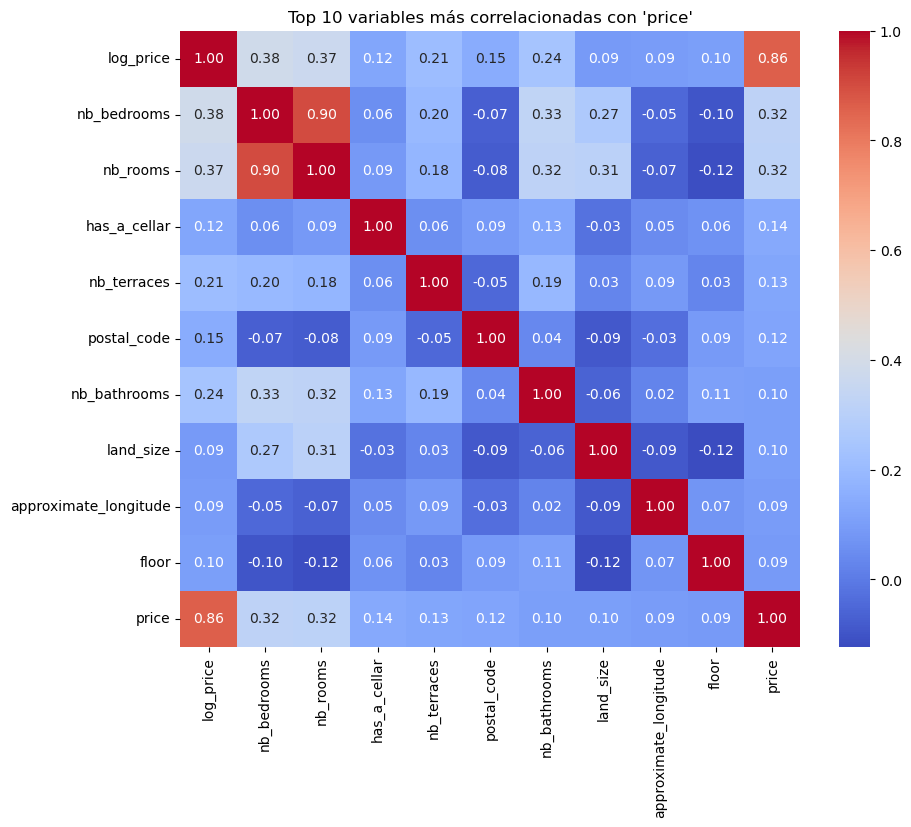

log_price                   0.859823
nb_bedrooms                 0.319178
nb_rooms                    0.315884
has_a_cellar                0.138555
nb_terraces                 0.126785
postal_code                 0.121038
nb_bathrooms                0.104789
land_size                   0.101730
approximate_longitude       0.094289
floor                       0.091498
nb_parking_places           0.061310
has_a_balcony               0.060202
sqrt_size                   0.059464
has_air_conditioning        0.055814
last_floor                  0.048213
has_a_garage                0.039552
approximate_latitude        0.034752
nb_bedrooms_over_rooms      0.031862
nb_boxes                    0.028291
size                        0.022070
size_over_landsize          0.013164
upper_floors               -0.005655
id_annonce                 -0.013907
size_over_rooms            -0.020850
energy_performance_value   -0.195669
Name: price, dtype: float64

In [57]:
# Calcular la matriz de correlación solo para columnas numéricas
corr_matrix = df.select_dtypes(include=[np.number]).corr()

# Extraer correlación con la variable objetivo 'price' y ordenarla
correlaciones_con_price = corr_matrix['price'].drop('price').sort_values(ascending=False)

# Visualizar con un heatmap sólo las 10 más correlacionadas
top_corr = correlaciones_con_price.head(10).index.tolist()

plt.figure(figsize=(10, 8))
sns.heatmap(df[top_corr + ['price']].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Top 10 variables más correlacionadas con 'price'")
plt.show()

correlaciones_con_price

In [58]:
# Variables numéricas (excepto columnas que no se deben usar como features)
columnas_excluir = ['id_annonce', 'price', 'log_price']
X = df.select_dtypes(include=[np.number]).drop(columns=columnas_excluir)
y = df['log_price']

Listamos las 3 características más correlacionadas con nuestra variable objetivo

In [59]:
correlaciones = df.select_dtypes(include=[np.number]).corr()

correlaciones_y = correlaciones['log_price'].drop(['log_price', 'price'])
top3 = correlaciones_y.abs().sort_values(ascending=False).head(3)
top3

nb_bedrooms                 0.382387
nb_rooms                    0.367374
energy_performance_value    0.348886
Name: log_price, dtype: float64

# Dataset final

In [60]:
# Creamos el dataset final con las 3 variables seleccionadas

features_finales = top3.index.to_list()
df_final = df[features_finales + ['log_price']]
df_final.head()

,nb_bedrooms,nb_rooms,energy_performance_value,log_price
0,2.0,3.0,173.0,12.779873
1,4.0,5.0,223.0,12.154779
2,1.0,2.0,188.0,10.571317
3,3.0,4.0,217.0,12.608199
4,3.0,4.0,173.0,13.077366


# Entrenamiento de la regresión polinomial con grado variable.

In [61]:
X = df_final[features_finales]
y = df_final['log_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [62]:
def entrena_regresion_polinomial(X_train, X_test, y_train, y_test, grado):
    poly = PolynomialFeatures(degree = grado, include_bias = True)
    
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)
    
    modelo = LinearRegression()
    modelo.fit(X_train_poly, y_train)
    
    # Predicciones
    y_pred_train = modelo.predict(X_train_poly)
    y_pred_test = modelo.predict(X_test_poly)
    
    # Metricas
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)
    
    # Conteo de parámetros
    n_params = X_train_poly.shape[1]
    
    return mse_train, mse_test, n_params

In [63]:
resultados_polinomial = []

for grado in range(1, 16):
    mse_train, mse_test, n_params = entrena_regresion_polinomial(
        X_train, X_test, y_train, y_test, grado
    )
    
    resultados_polinomial.append({
        'grado': grado,
        'mse_train': mse_train,
        'mse_test': mse_test,
        'parametros': n_params
    })

df_resultados_polinomial = pd.DataFrame(resultados_polinomial)
print(df_resultados_polinomial)

    grado  mse_train     mse_test  parametros
0       1   0.511196     0.508492           4
1       2   0.504282     0.501793          10
2       3   0.499832     0.494541          20
3       4   0.494729     0.490795          35
4       5   0.545660     0.592182          56
5       6   0.581645     1.199294          84
6       7   0.765066    12.662540         120
7       8   1.787332    74.901586         165
8       9   0.560659    11.635633         220
9      10   0.842994     8.277184         286
10     11   0.630904    59.371359         364
11     12   1.108553  1091.293781         455
12     13   0.595617  2861.559637         560
13     14   0.585196     3.212084         680
14     15   0.586081    85.516656         816


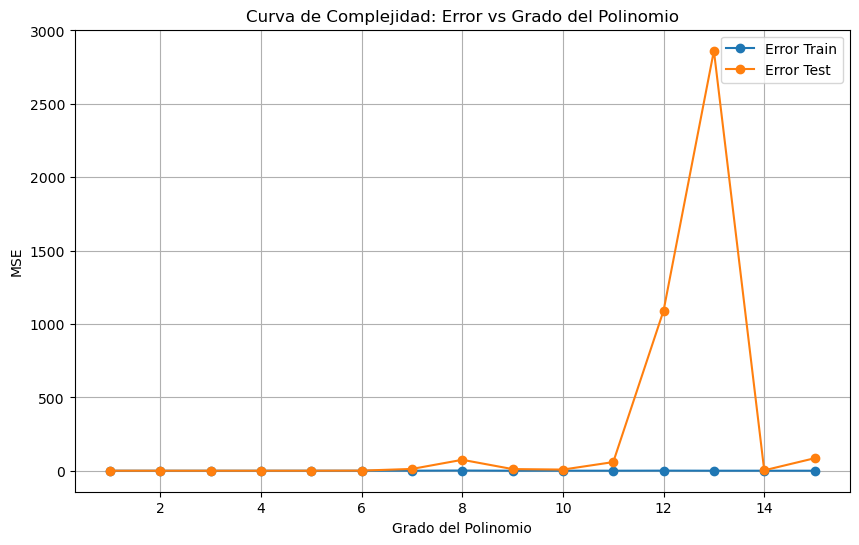

In [64]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(df_resultados_polinomial['grado'], df_resultados_polinomial['mse_train'], 'o-', label='Error Train')
plt.plot(df_resultados_polinomial['grado'], df_resultados_polinomial['mse_test'], 'o-', label='Error Test')

plt.xlabel('Grado del Polinomio')
plt.ylabel('MSE')
plt.title('Curva de Complejidad: Error vs Grado del Polinomio')
plt.legend()
plt.grid(True)
plt.show()

Podemos concluir que usando una regresion polinomial, se observa que al crecer el grado va haciendo sobre ajuste debido al nivel de combinaciones que se esta realizando por lo que esto afecta en el conjunto de prueba.

# Entrenamiento de la Red Neuronal con neuronas/capas variables.

Normalizamos nuestros datos.

In [65]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [66]:
def entrena_red(neuronas_por_capa):
    model = Sequential()
    
    # Capa de entrada
    model.add(Dense(neuronas_por_capa[0], activation = 'relu', input_shape = (X_train_scaled.shape[1], )))
    
    # Capas ocultas adicionales
    for n in neuronas_por_capa[1: ]:
        model.add(Dense(n, activation = 'relu'))
        
    # Capa de salida (regresión)
    model.add(Dense(1, activation = 'linear'))
    model.compile(optimizer = Adam(learning_rate = 0.01), loss = 'mse')
    
    historial = model.fit(
        X_train_scaled, y_train,
        epochs = 100,
        batch_size = 32,
        verbose = 0,
        validation_data = (X_test_scaled, y_test)
    )
    
    mse_train = historial.history['loss'][-1]
    mse_test = historial.history['val_loss'][-1]
    parametros = model.count_params()
    
    return mse_train, mse_test, parametros

In [67]:
arquitecturas = [
    [5],
    [10],
    [20],
    [10, 10],
]

resultados_nn = []

for arch in arquitecturas:
    mse_train, mse_test, params = entrena_red(arch)
    resultados_nn.append({
        "arquitectura": str(arch),
        "mse_train": mse_train,
        "mse_test": mse_test,
        "parametros": params
    })

df_nn = pd.DataFrame(resultados_nn)
df_nn

,arquitectura,mse_train,mse_test,parametros
0,[5],0.680234,0.611201,26
1,[10],1.151935,52.468437,51
2,[20],1.782564,0.793428,101
3,"[10, 10]",127.932732,0.528886,161


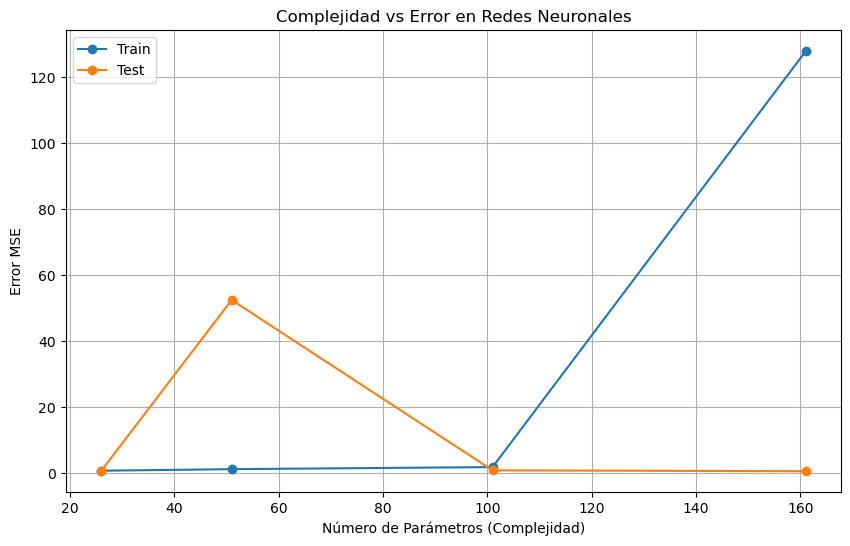

In [68]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(df_nn['parametros'], df_nn['mse_train'], 'o-', label="Train")
plt.plot(df_nn['parametros'], df_nn['mse_test'], 'o-', label="Test")
plt.xlabel("Número de Parámetros (Complejidad)")
plt.ylabel("Error MSE")
plt.title("Complejidad vs Error en Redes Neuronales")
plt.legend()
plt.grid(True)
plt.show()